In [4]:
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import optuna

# Data loading

# Problem

Задача бинарной классификации, необходимо по имеющимся данным определить, предрасположен ли человек к возникновению инсульта в будущем.

- id: уникальный идентификатор.
- gender: пол: мужской, женский, другое.
- age: возраст пациента.
- hypertension: диагностирована ли у пациента гипертония (0 - нет, 1 - да).
- heart_disease: диагностированы ли у пациента болезни сердца (0 - нет, 1 - да).
- ever married: был ли пациента когда-либо женат/замужем.
- work-type: вид работы (работа с детьми, работа на государственной службе, никогда не работал(а), частная работа, самозанятый(ая)).
- Residence_type: место жительства (сельская местность, город).
- avg_glucose_level: средний уровень глюкозы в крови.
- bmi: значение ИМТ - индекса массы тела.
- smoking_status: отношение к курению (курил(а) в прошлом, никогда не курил(а), курит в настоящий момент, инофрмация неизвестна).
- stroke: таргетный признак, выявлен инсульт или нет (0 - нет, 1 - да). 

In [5]:
dataset = pd.read_csv("./healthcare-dataset-stroke-data.csv")
dataset.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [6]:
dataset.drop(['id'], axis = 1, inplace = True)

In [7]:
dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [8]:
categorical_columns = [i for i in dataset.columns if dataset[i].dtype == 'object']
numerical_columns = [i for i in dataset.columns if dataset[i].dtype != 'object' and i != 'stroke']
print(categorical_columns)
print(numerical_columns)

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


In [9]:
for i in categorical_columns:
    print(i, dataset[i].unique())

gender ['Male' 'Female' 'Other']
ever_married ['Yes' 'No']
work_type ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type ['Urban' 'Rural']
smoking_status ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


# Data visualization

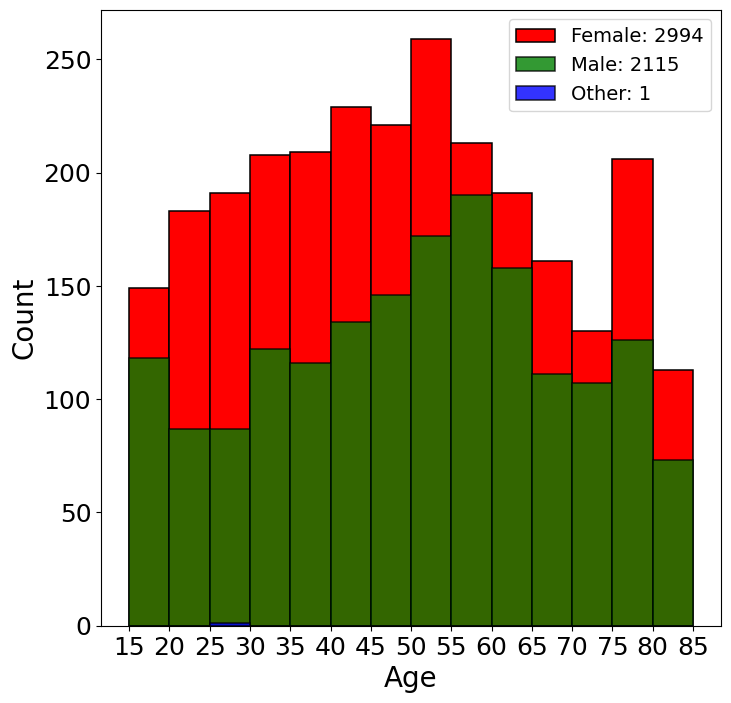

In [10]:
plt.figure(figsize=(8, 8))
plt.hist(dataset['age'].loc[dataset['gender'] == 'Female'], bins=np.arange(15, 90, 5), color='red', edgecolor='black', linewidth=1.1, label=f"Female: {len(dataset[dataset['gender'] == 'Female'])}")
plt.hist(dataset['age'].loc[dataset['gender'] == 'Male'], bins=np.arange(15, 90, 5), color='green', alpha = 0.8, edgecolor='black', linewidth=1.1, label=f"Male: {len(dataset[dataset['gender'] == 'Male'])}")
plt.hist(dataset['age'].loc[dataset['gender'] == 'Other'], bins=np.arange(15, 90, 5), color='blue', alpha = 0.8, edgecolor='black', linewidth=1.1, label=f"Other: {len(dataset[dataset['gender'] == 'Other'])}")
plt.xticks(np.arange(15, 90, 5), fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Age', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(fontsize=14)
plt.show()

Из гистограмы видно, что датасет по возрасту достаточно сбалансированый, но наибольшее количество пациентов имеют возраст в диапазоне 50-55 лет. Так же можно заметить, что большинство пациентов - женщины.

## Missing data preprocessing

In [11]:
dataset.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [12]:
dataset['bmi'] = dataset['bmi'].fillna(dataset['bmi'].median(axis = 0), axis = 0)

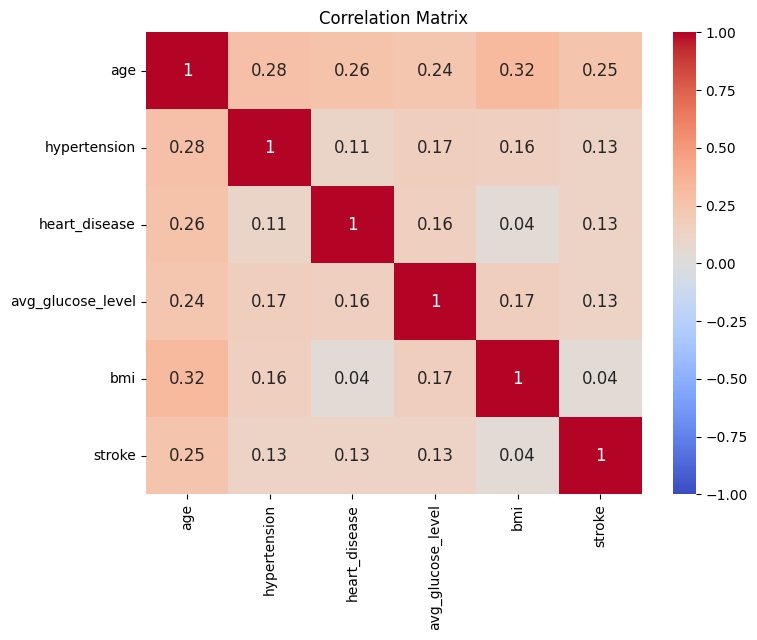

In [13]:
pearson_corr_df = pd.DataFrame(columns=dataset.copy().drop(categorical_columns, axis=1).columns).astype(float)

for col1 in dataset:
    for col2 in dataset:
        if pd.api.types.is_numeric_dtype(dataset[col1]) and pd.api.types.is_numeric_dtype(dataset[col2]):
            r, p = stats.pearsonr(dataset[col1], dataset[col2])
            pearson_corr_df.loc[col1, col2] = round(r, 2)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr_df, annot=True, cmap='coolwarm', annot_kws={"size": 12}, vmin = -1, vmax = 1)
plt.title('Correlation Matrix')

plt.show()

Наиболее коррелирующим с таргетной переменной признаком является индекс массы тела.

<Axes: >

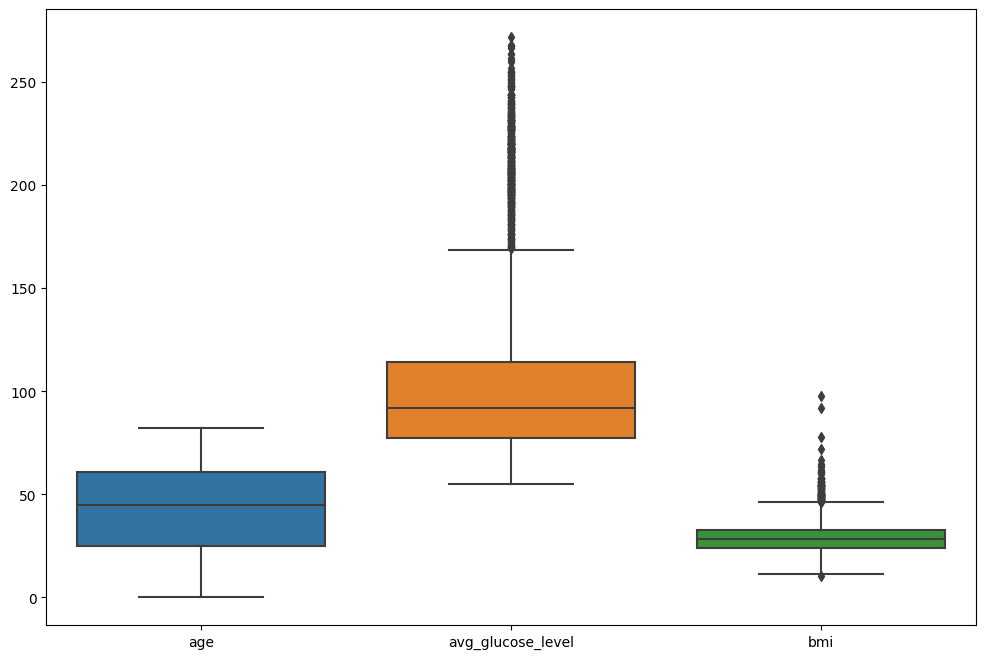

In [14]:
plt.figure(figsize=(12, 8))
sns.boxplot(dataset[['age', 'avg_glucose_level', 'bmi']])

Из графика можно заметить, что признаки avg_glucose_level и bmi имеют множество выбросов.

In [15]:
dataset.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.862035,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.699562,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


# Categorical data preprocessing

In [16]:
binary_columns = [i for i in categorical_columns if len(dataset[i].unique()) == 2]
nonbinary_columns = [i for i in categorical_columns if len(dataset[i].unique()) > 2]
print(binary_columns, nonbinary_columns)

['ever_married', 'Residence_type'] ['gender', 'work_type', 'smoking_status']


## Binary categorical features preprocessing

In [17]:
print(dataset['Residence_type'].unique(), dataset['ever_married'].unique())

['Urban' 'Rural'] ['Yes' 'No']


In [18]:
dataset['Residence_type'] = dataset['Residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)
dataset['ever_married'] = dataset['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)
dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,0,202.21,28.1,never smoked,1
2,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,1,Private,1,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


# Nonbinary categorical features preprocessing

In [19]:
dataset_nonbinary = pd.get_dummies(dataset[nonbinary_columns])
print(dataset_nonbinary.columns)

Index(['gender_Female', 'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


# Normalization

In [20]:
dataset_numerical = dataset[numerical_columns]
dataset_numerical.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.862035
std,22.612647,0.296607,0.226063,45.283560,7.699562
min,0.080000,0.000000,0.000000,55.120000,10.300000
25%,25.000000,0.000000,0.000000,77.245000,23.800000
50%,45.000000,0.000000,0.000000,91.885000,28.100000
75%,61.000000,0.000000,0.000000,114.090000,32.800000
max,82.000000,1.000000,1.000000,271.740000,97.600000


In [21]:
dataset_numerical = (dataset_numerical - dataset_numerical.mean(axis = 0))/dataset_numerical.std(axis = 0)
dataset_numerical.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03
mean,3.893385e-17,2.780989e-18,3.615286e-17,1.001156e-16,-4.171484e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.908074e+00,-3.285697e-01,-2.389234e-01,-1.126848e+00,-2.410791e+00
25%,-8.060363e-01,-3.285697e-01,-2.389234e-01,-6.382598e-01,-6.574445e-01
50%,7.842450e-02,-3.285697e-01,-2.389234e-01,-3.149637e-01,-9.897124e-02
75%,7.859932e-01,-3.285697e-01,-2.389234e-01,1.753909e-01,5.114531e-01
max,1.714677e+00,3.042899e+00,4.184622e+00,3.656787e+00,8.927516e+00


In [22]:
dataset = pd.concat([dataset_numerical, dataset_nonbinary, dataset[binary_columns], dataset['stroke']], axis = 1)
dataset

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,ever_married,Residence_type,stroke
0,1.051331,-0.328570,4.184622,2.706111,1.004988,False,True,False,False,False,True,False,False,False,True,False,False,1,1,1
1,0.785993,-0.328570,-0.238923,2.121351,-0.098971,True,False,False,False,False,False,True,False,False,False,True,False,1,0,1
2,1.626231,-0.328570,4.184622,-0.005028,0.472490,False,True,False,False,False,True,False,False,False,False,True,False,1,0,1
3,0.255317,-0.328570,-0.238923,1.437217,0.719257,True,False,False,False,False,True,False,False,False,False,False,True,1,1,1
4,1.582008,3.042899,-0.238923,1.501038,-0.631469,True,False,False,False,False,False,True,False,False,False,True,False,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.626231,3.042899,-0.238923,-0.494609,-0.098971,True,False,False,False,False,True,False,False,False,False,True,False,1,1,0
5106,1.670454,-0.328570,-0.238923,0.420734,1.446571,True,False,False,False,False,False,True,False,False,False,True,False,1,1,0
5107,-0.363806,-0.328570,-0.238923,-0.511393,0.225723,True,False,False,False,False,False,True,False,False,False,True,False,1,0,0
5108,0.343763,-0.328570,-0.238923,1.328127,-0.423665,False,True,False,False,False,True,False,False,False,True,False,False,1,0,0


# Splitting dataset

In [23]:
X = dataset.drop(['stroke'], axis = 1)
y = dataset['stroke']

In [24]:
X = X.to_numpy()
y = np.array(y)

In [25]:
print(X.shape, y.shape)

(5110, 19) (5110,)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)

In [27]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
print(N_train, N_test)

3577 1533


# KNN

In [170]:
knn = KNeighborsClassifier(n_neighbors = 6)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [171]:
y_predicted = knn.predict(X_test)
err_test = np.mean(y_predicted != y_test)
err_test

0.04957599478147423

# Hyperparameters search

In [175]:
def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 10)
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(X_train, y_train)
    y_predicted = knn.predict(X_test)
    err_test = np.mean(y_predicted != y_test)
    return err_test

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

best_params = study.best_params
print('Best params:', best_params)

[I 2023-11-03 14:50:04,431] A new study created in memory with name: no-name-80bbe4a7-4bea-4d42-a874-2e288ada6c3a


[I 2023-11-03 14:50:04,744] Trial 0 finished with value: 0.0502283105022831 and parameters: {'n_neighbors': 7}. Best is trial 0 with value: 0.0502283105022831.
[I 2023-11-03 14:50:04,997] Trial 1 finished with value: 0.06196999347684279 and parameters: {'n_neighbors': 3}. Best is trial 0 with value: 0.0502283105022831.
[I 2023-11-03 14:50:05,068] Trial 2 finished with value: 0.08741030658838878 and parameters: {'n_neighbors': 1}. Best is trial 0 with value: 0.0502283105022831.
[I 2023-11-03 14:50:05,134] Trial 3 finished with value: 0.04957599478147423 and parameters: {'n_neighbors': 8}. Best is trial 3 with value: 0.04957599478147423.
[I 2023-11-03 14:50:05,189] Trial 4 finished with value: 0.050880626223091974 and parameters: {'n_neighbors': 5}. Best is trial 3 with value: 0.04957599478147423.
[I 2023-11-03 14:50:05,241] Trial 5 finished with value: 0.04957599478147423 and parameters: {'n_neighbors': 9}. Best is trial 3 with value: 0.04957599478147423.
[I 2023-11-03 14:50:05,294] Tri

Best params: {'n_neighbors': 8}


In [176]:
knn = KNeighborsClassifier(**best_params)

knn.fit(X_train, y_train)

y_predicted = knn.predict(X_test)
err_test = np.mean(y_predicted != y_test)
err_test

0.04957599478147423

# LogisticRegression

In [125]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

y_predicted = logistic_regression.predict(X_test)
err_test = np.mean(y_predicted != y_test)

print(err_test)

0.0502283105022831


# RandomForestClassifier

In [141]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

y_predicted = random_forest.predict(X_test)
err_test = np.mean(y_predicted != y_test)

print(err_test)

0.051532941943900845


# StraightforwardNet

In [116]:
import torch

from torch import nn

class Classificator(nn.Module):
    def __init__(self):
        super(Classificator, self).__init__()
        self.fc1 = nn.Linear(in_features=19, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=2)

        self.relu = nn.ReLU()

        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
clf = Classificator()
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(clf.parameters(), lr=learning_rate)

num_epochs = 400

for epoch in range(num_epochs):
    y_predicted = clf(torch.tensor(X_train.astype(np.float32)))
    loss = criterion(y_predicted, torch.tensor(y_train))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/400], Loss: 0.7293
Epoch [2/400], Loss: 0.7118
Epoch [3/400], Loss: 0.6945
Epoch [4/400], Loss: 0.6773
Epoch [5/400], Loss: 0.6603
Epoch [6/400], Loss: 0.6433
Epoch [7/400], Loss: 0.6264
Epoch [8/400], Loss: 0.6094
Epoch [9/400], Loss: 0.5924
Epoch [10/400], Loss: 0.5753
Epoch [11/400], Loss: 0.5582
Epoch [12/400], Loss: 0.5411
Epoch [13/400], Loss: 0.5239
Epoch [14/400], Loss: 0.5068
Epoch [15/400], Loss: 0.4896
Epoch [16/400], Loss: 0.4726
Epoch [17/400], Loss: 0.4556
Epoch [18/400], Loss: 0.4389
Epoch [19/400], Loss: 0.4224
Epoch [20/400], Loss: 0.4061
Epoch [21/400], Loss: 0.3901
Epoch [22/400], Loss: 0.3745
Epoch [23/400], Loss: 0.3594
Epoch [24/400], Loss: 0.3447
Epoch [25/400], Loss: 0.3307
Epoch [26/400], Loss: 0.3173
Epoch [27/400], Loss: 0.3047
Epoch [28/400], Loss: 0.2928
Epoch [29/400], Loss: 0.2817
Epoch [30/400], Loss: 0.2715
Epoch [31/400], Loss: 0.2620
Epoch [32/400], Loss: 0.2534
Epoch [33/400], Loss: 0.2456
Epoch [34/400], Loss: 0.2385
Epoch [35/400], Loss: 0

In [118]:
with torch.no_grad():
    y_pred = clf(torch.tensor(X_test.astype(np.float32)))

y_pred_np = y_pred.numpy()

predicted_labels = np.argmax(y_pred_np, axis=1)

err_test = np.mean(predicted_labels != y_test)

print(err_test)

0.04957599478147423


# RandomForest HyperParameters search

In [142]:
def objective(trial):
    
    n_estimators = trial.suggest_int("n_estimators", 1, 100)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)

    random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    random_forest.fit(X_train, y_train)
    y_predicted = random_forest.predict(X_test)
    err_test = np.mean(y_predicted != y_test)

    return err_test

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

best_params = study.best_params
print('Best params:', best_params)

random_forest = RandomForestClassifier(**best_params)

random_forest.fit(X_train, y_train)

y_predicted = random_forest.predict(X_test)
err_test = np.mean(y_predicted != y_test)
print(err_test)

[I 2023-12-25 22:51:27,984] A new study created in memory with name: no-name-6f7c05c4-10ee-42b9-b640-4896d4f89bb3
[I 2023-12-25 22:51:28,169] Trial 0 finished with value: 0.0502283105022831 and parameters: {'n_estimators': 34, 'max_depth': 2, 'min_samples_split': 5}. Best is trial 0 with value: 0.0502283105022831.
[I 2023-12-25 22:51:28,596] Trial 1 finished with value: 0.0502283105022831 and parameters: {'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 7}. Best is trial 0 with value: 0.0502283105022831.
[I 2023-12-25 22:51:28,653] Trial 2 finished with value: 0.050880626223091974 and parameters: {'n_estimators': 8, 'max_depth': 9, 'min_samples_split': 4}. Best is trial 0 with value: 0.0502283105022831.
[I 2023-12-25 22:51:28,955] Trial 3 finished with value: 0.0502283105022831 and parameters: {'n_estimators': 99, 'max_depth': 2, 'min_samples_split': 6}. Best is trial 0 with value: 0.0502283105022831.
[I 2023-12-25 22:51:29,024] Trial 4 finished with value: 0.050880626223091974

Best params: {'n_estimators': 34, 'max_depth': 2, 'min_samples_split': 5}
0.0502283105022831


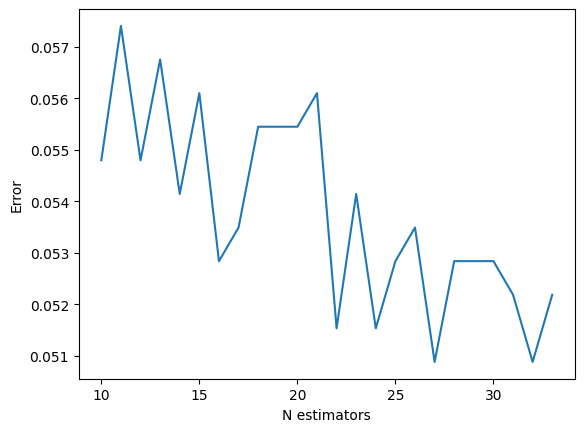

In [145]:
errors = []

for i in range(10, 34):
    random_forest = RandomForestClassifier(n_estimators=i)
    random_forest.fit(X_train, y_train)

    y_predicted = random_forest.predict(X_test)
    err_test = np.mean(y_predicted != y_test)
    errors.append(err_test)

plt.plot(range(10, 34), errors)
plt.ylabel('Error')
plt.xlabel('N estimators')
plt.show()

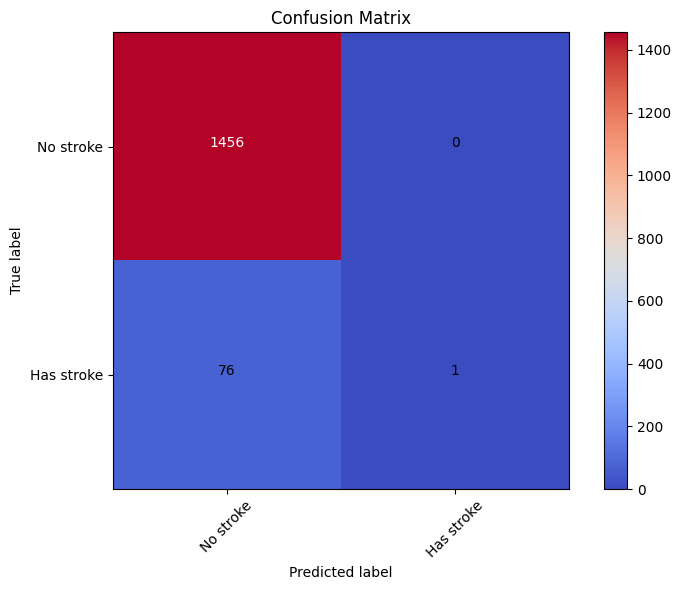

In [150]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, predicted_labels)

class_labels = ['No stroke', 'Has stroke']  # Update with your actual class labels

plt.figure(figsize=(8, 6))
plt.imshow(matrix, interpolation='nearest', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = matrix.max() / 2.0
for i, j in np.ndindex(matrix.shape):
    plt.text(j, i, format(matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Выводы

Переобучение или недообучение не наблюдается ни у одной модели, все модели имеют ошибку ~5%, для дальнейшего уменьшения ошибки, можно применять feature selection, аугментацию и другие операции с данными, но в целом всем модели показывают хорошие результаты. Модель простой MLP сети показывает слека лучший результат, с ошибкой <5%.
Больше всего ошибок у нейросети, так называемых Type 2 Error, что в целом не очень хорошо в рамках данной темы, потому что речь идёт о серьёзном заболевании.
Модель в принципе не распознаёт болезнь у человека, что делает её в общем-то бесполезной.

0.05283757338551859


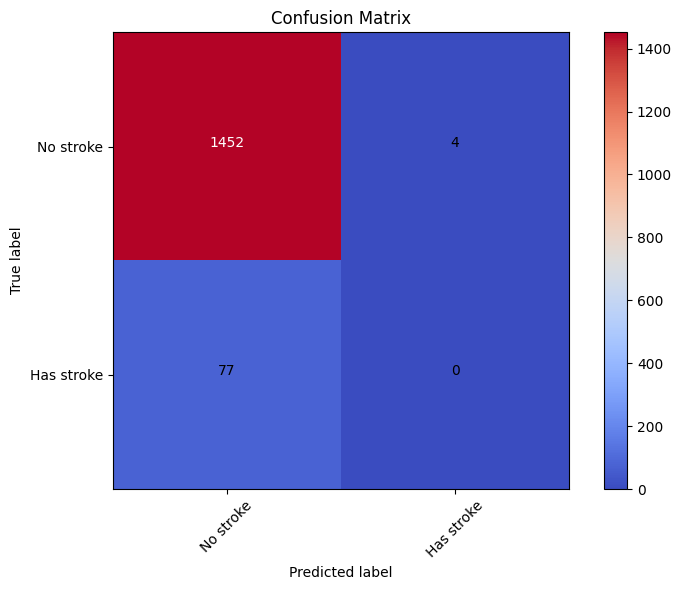

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

y_predicted = random_forest.predict(X_test)
err_test = np.mean(y_predicted != y_test)

print(err_test)

matrix = confusion_matrix(y_test, y_predicted)

class_labels = ['No stroke', 'Has stroke']  # Update with your actual class labels

plt.figure(figsize=(8, 6))
plt.imshow(matrix, interpolation='nearest', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = matrix.max() / 2.0
for i, j in np.ndindex(matrix.shape):
    plt.text(j, i, format(matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

0.0502283105022831


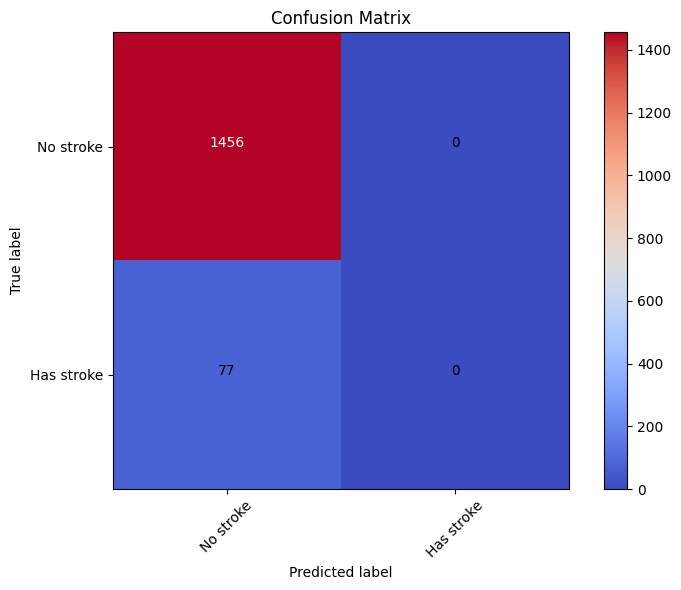

In [153]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

y_predicted = logistic_regression.predict(X_test)
err_test = np.mean(y_predicted != y_test)

print(err_test)

matrix = confusion_matrix(y_test, y_predicted)

class_labels = ['No stroke', 'Has stroke']  # Update with your actual class labels

plt.figure(figsize=(8, 6))
plt.imshow(matrix, interpolation='nearest', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = matrix.max() / 2.0
for i, j in np.ndindex(matrix.shape):
    plt.text(j, i, format(matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

То же самое касается и остальных моделей, датасет очень не сбалансрованный, поэтому ни одна модель не может правильно классифицировать больных людей.

0.589041095890411


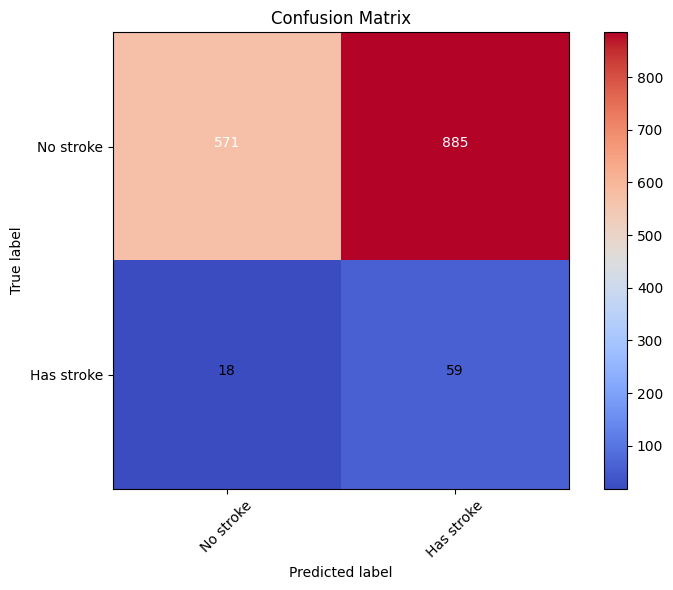

In [164]:
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss

pipeline = make_pipeline(NearMiss(), RandomForestClassifier(**best_params))
pipeline.fit(X_train, y_train)

y_predicted = pipeline.predict(X_test)
err_test = np.mean(y_predicted != y_test)

print(err_test)

matrix = confusion_matrix(y_test, y_predicted)

class_labels = ['No stroke', 'Has stroke']  # Update with your actual class labels

plt.figure(figsize=(8, 6))
plt.imshow(matrix, interpolation='nearest', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = matrix.max() / 2.0
for i, j in np.ndindex(matrix.shape):
    plt.text(j, i, format(matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Если применить библиотеку для борьбы с imbalanced learning, без особых настроек, то сразу же получаем такой результат: общая точность заметно снизилась (что наверное можно исправить, если почитать документацию библиотеки и понаходить параметры), но зато Type 2 Error значительно снизилась и теперь модель достаточно хорошо определяет наличие заболевания у человека, что в моём понимании, даже с такой низкой точность, всё равно лучше, чем все предыдущие модели.